In [3]:
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
import rosbag
import pandas as pd
from scipy import integrate
from scipy.interpolate import interp1d

In [4]:
filename='2018-09-19-Alumnai-Yolo2'

bag  = rosbag.Bag('/home/maleen/' + filename + '.bag')

In [5]:
encsize=0
yolosize=0

encoder_time=np.array([])
encoder_seq=np.array([])
encoder_x=np.array([])
encoder_y=np.array([])

yolo_time=np.array([])
yolo_seq=np.array([])
image_time=np.array([])
image_seq=np.array([])
bounding_box=[]

imuraw_time=np.array([])
imuraw_seq=np.array([])
imuraw_angaccZ=np.array([])

imureal_time=np.array([])
imureal_seq=np.array([])
imureal_angvZ=np.array([])


for topic, msg, t in bag.read_messages(topics=['/encoder_ticks_ts', '/darknet_ros/bounding_boxes','/imuraw_ts','/imureal_ts']):
    
        if topic=='/encoder_ticks_ts':
            
            encoder_time=np.append(encoder_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            encoder_seq=np.append(encoder_seq,msg.header.seq)
            encoder_x=np.append(encoder_x,msg.ticks.x)
            encoder_y=np.append(encoder_y,msg.ticks.y)
            encsize=encsize+1
            
        elif topic=='/darknet_ros/bounding_boxes':
            
            yolo_time=np.append(yolo_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            yolo_seq=np.append(yolo_seq,msg.header.seq)
            
            image_time=np.append(image_time,(msg.image_header.stamp.secs)+(Decimal(msg.image_header.stamp.nsecs)/1000000000))
            image_seq=np.append(image_seq,msg.image_header.seq)
            
            bounding_box.append(msg.bounding_boxes)
            
            yolosize=yolosize+1
            
        elif topic=='/imuraw_ts':
        
            imuraw_time=np.append(imuraw_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            imuraw_seq=np.append(imuraw_seq,msg.header.seq)
            imuraw_angaccZ=np.append(imuraw_angaccZ, msg.gyroscope.z)
            #print msg
            
        elif topic=='/imureal_ts':
        
            imureal_time=np.append(imureal_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            imureal_seq=np.append(imureal_seq,msg.header.seq)
            #print msg
            imureal_angvZ=np.append(imureal_angvZ,(msg.angular_velocity.z))
            
bag.close()

In [6]:
print imureal_time[0]
print np.float64(encoder_time)

1537341158.892967939
[  1.53734116e+09   1.53734116e+09   1.53734116e+09 ...,   1.53734139e+09
   1.53734139e+09   1.53734139e+09]


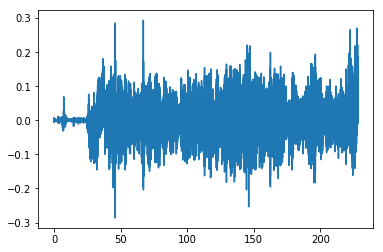

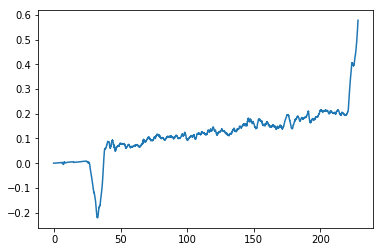

In [7]:
imureal_angvZ=imureal_angvZ-imureal_angvZ[0]
imureal_time=imureal_time-encoder_time[0]
plt.figure(1)
plt.plot(imureal_time,imureal_angvZ)
theta=integrate.cumtrapz(imureal_angvZ,np.float64(imureal_time),initial=0)

plt.figure(2)
plt.plot(imureal_time,theta)

In [8]:
encoderdata={'encoder_seq':encoder_seq, 'encoder_time':encoder_time-encoder_time[0], 'encoder_x':encoder_x, 'encoder_y':-encoder_y, 'encoder_mean':(encoder_x-encoder_y)/2}
encoder_df = pd.DataFrame(encoderdata, columns=['encoder_seq','encoder_time','encoder_x','encoder_y','encoder_mean'])
#print encoder_df

yolodata={'yolo_seq':yolo_seq, 'yolo_time':yolo_time-encoder_time[0],'image_seq':image_seq, 'image_time':image_time-encoder_time[0],'bounding_box':bounding_box}
yolo_df = pd.DataFrame(yolodata, columns=['yolo_seq','yolo_time','image_seq','image_time','bounding_box'])
#print yolo_df

imudata={'imureal_time':imureal_time, 'imureal_angvZ':imureal_angvZ, 'theta':theta}
imu_df = pd.DataFrame(imudata,columns=['imureal_time','imureal_angvZ','theta'])
#print imu_df


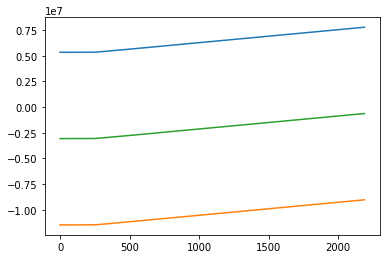

In [9]:
plt.plot(encoder_x)
plt.plot(-encoder_y)
plt.plot(encoder_df.loc[:,'encoder_mean'])



In [ ]:
enc_dist=np.array([])
dist=0
encXcalib=6.608284615932709e-05;
encYcalib=6.603486193757895e-05;
mean_calib=np.mean([encXcalib,encYcalib])
mean_theta=np.array([])
mean_enctime=np.array([])
#sorted_boxes={}
steps=0


for num in range(1,(encsize)):
    steps=steps+1
    
    dist=(encoder_df.loc[(num),'encoder_mean']-encoder_df.loc[(num-1),'encoder_mean'])*mean_calib
    enc_dist=np.append(enc_dist,dist)
    
    enctime_start=encoder_df.loc[(num-1),'encoder_time']
    enctime_end=encoder_df.loc[(num),'encoder_time']
    
    mean_enctime=np.append(mean_enctime,(enctime_start+enctime_end)/2)
    
    angles= imu_df.query('@enctime_start < imureal_time < @enctime_end').loc[:,'theta']
    
    mean_theta=np.append(mean_theta,angles.mean())
    
    #boxes= yolo_df.query('@enctime_start < image_time < @enctime_end').loc[:,'bounding_box']
    #sorted_boxes.update({str(steps): boxes})


In [ ]:
dx=np.multiply(enc_dist,np.cos(-mean_theta))
dy=np.multiply(enc_dist,np.sin(-mean_theta))
Xd=0
Yd=0
X_pos=np.array([])
Y_pos=np.array([])

for num in range(0,encsize-1):
    
    Xd=Xd+dx[num]
    Yd=Yd+dy[num]
    
    X_pos=np.append(X_pos,Xd)
    Y_pos=np.append(Y_pos,Yd)

    

plt.plot(X_pos,Y_pos)
plt.axis('equal')
plt.title('Path')
plt.show()

In [17]:
x_interp=interp1d(np.float64(mean_enctime), X_pos, kind='cubic')
y_interp=interp1d(np.float64(mean_enctime), Y_pos, kind='cubic')
mean_theta_interp=interp1d(np.float64(mean_enctime), mean_theta, kind='cubic')


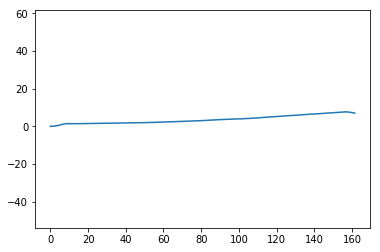

In [18]:
plt.plot(x_interp(np.float64(mean_enctime)),y_interp(np.float64(mean_enctime)))
plt.axis('equal')
plt.show()

In [19]:
ind=0
bench_boxes=pd.DataFrame()
for key,value in yolo_df.iteritems():
   
    if key=='bounding_box':
        for detects in value:
               
            for obj in detects:
                   if obj.Class=='streetlamp':
        
                        bench_boxes=bench_boxes.append(yolo_df.iloc[ind,:],ignore_index=True)
                       
            ind=ind+1
            
            
            

In [20]:
def getyolobearing(times, dimensions, x_interp, y_interp):
    
    h_fov=np.deg2rad(69.4)
    h_width=640
    centerX=h_width/2
    
    rad_per_pix=h_fov/h_width

    centroids=np.zeros((dimensions.shape[0],2))
    bearings=np.zeros(dimensions.shape[0])
    gradients=np.zeros(dimensions.shape[0])
    intercepts=np.zeros(dimensions.shape[0])
    
  
    centroids[:,0]=(dimensions[:,0]+dimensions[:,2])/2
    centroids[:,1]=(dimensions[:,1]+dimensions[:,3])/2
    
    bearings=(centroids[:,0]-centerX)*rad_per_pix
    gradients=np.tan(bearings)
    
    intercepts=y_interp(np.float64(times))-np.multiply(gradients, x_interp(np.float64(times)))
    
    return bearings


In [21]:
bench_dimensions=np.array([])
bench_times=np.array([])


for row_index,row in bench_boxes.iterrows():
    
        for obj in row[0]:
             if obj.Class=='streetlamp':
                bench_dimensions=np.append(bench_dimensions,[obj.xmin,obj.ymin,obj.xmax,obj.ymax])
                bench_times=np.append(bench_times,row[2])
                 
                    
                   
                
bench_dimensions=np.reshape(bench_dimensions, (bench_dimensions.size/4, 4))                  

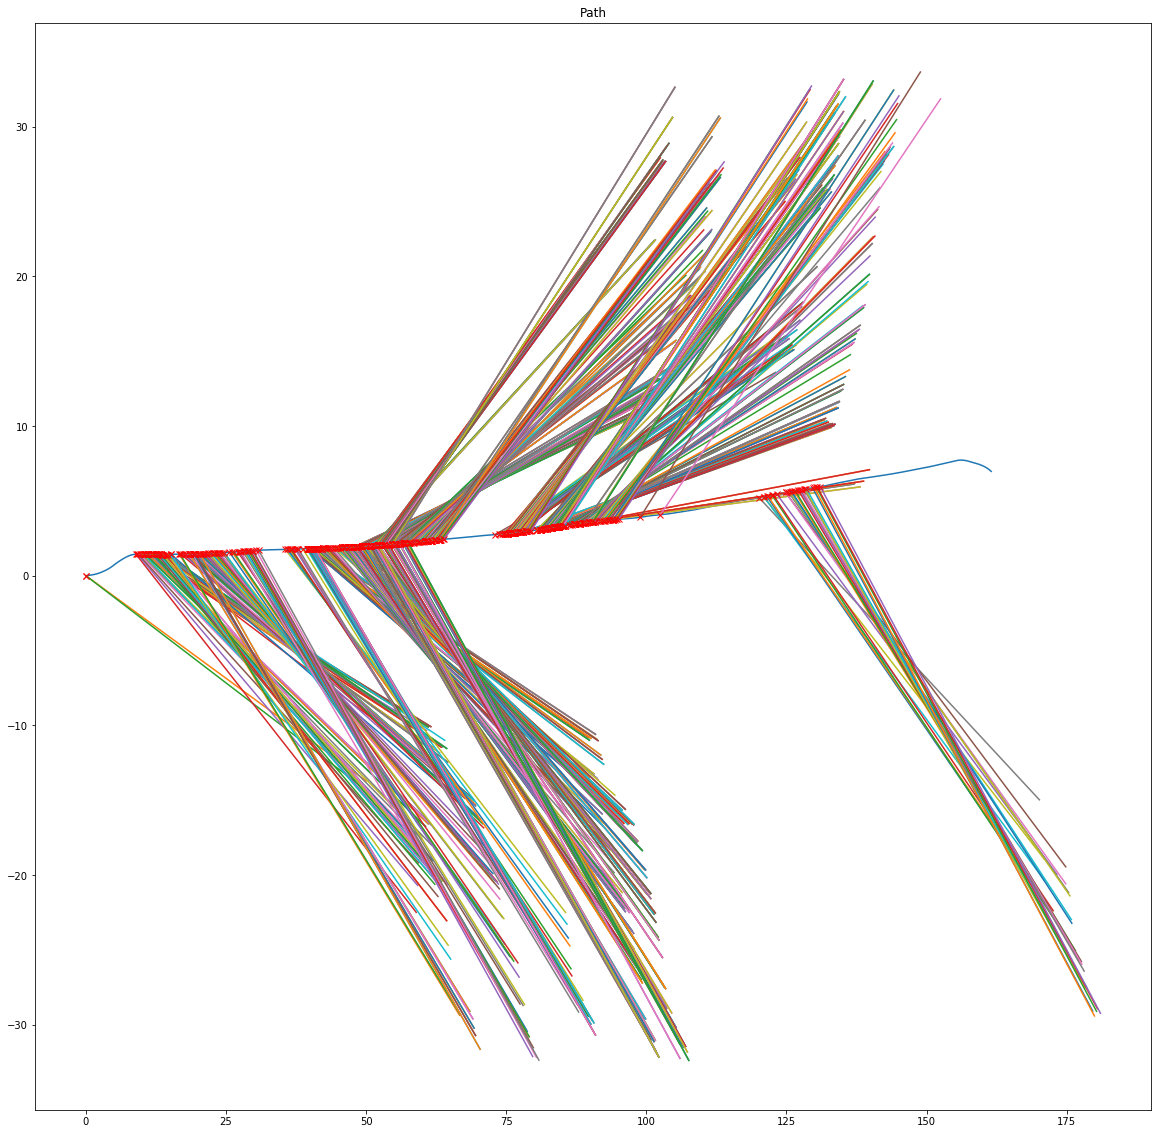

In [22]:
bearings=getyolobearing(bench_times,bench_dimensions,x_interp, y_interp) 

plt.rcParams['figure.figsize'] = [20,20]
plt.plot(X_pos,Y_pos)
#plt.axis('equal')
plt.title('Path')
#plt.plot(x_interp(np.float64(bench_times)),y_interp(np.float64(bench_times)),'rx')



for i in range(0,bench_dimensions.shape[0]):
#for i in range(0,10):
    
    samp_time=bench_times[i]
    scooter_x=x_interp(np.float64(samp_time))
    scooter_y=y_interp(np.float64(samp_time))
    scooter_theta=mean_theta_interp(np.float64(samp_time))
    
    xplotz=np.linspace(0, 50, num=100)
    
    yplotz=np.multiply(xplotz, np.tan(np.add(scooter_theta,-bearings[i])))
    
    plt.plot((xplotz+scooter_x),yplotz+scooter_y)
    plt.plot(scooter_x,scooter_y,'rx')
    
    
plt.show()

In [27]:
mean_enctime

array([Decimal('0.052162528'), Decimal('0.1562939885'),
       Decimal('0.2605448965'), ..., Decimal('254.257109523'),
       Decimal('254.363362432'), Decimal('254.470783949')], dtype=object)

2442